# AutoGluon.TimeSeries Tutorial

In [3]:
import pandas as pd
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

## If you want to make the plots that I do install plotnine (pip install plotnine)
import plotnine as p9

## If you want to get different covidcast indicators then (pip install covidcast)
# import covidcast

## Obtaining Covidcast Data

We will forecast the Covid-19 incidence proportion using the [Covidcast API](http://delphi.cmu.edu) which provides a large array of key Covid indicators.  We will focus on forecasting the indicators `smoothed_cli` and `case_prop` which is a measure of the Covid-like illnesses from a survey administered on Facebook, and the official case proportion `case_prop`.  We provide the code to gather the data so that if desired you can obtain more indicators and potentially improve the prediction performance.

In [2]:
## Only run if you want different data that that provided in s3 (see below)

# cli_data = covidcast.signal("fb-survey", "smoothed_cli",
#                         date(2020, 7, 1), date(2021, 7, 1),
#                         "state")

# covid_data = covidcast.signal("usa-facts", "confirmed_incidence_prop",
#                         date(2020, 7, 1), date(2021, 7, 1),
#                         "state")

In [4]:
# cli_data = cli_data[['geo_value', 'time_value', 'value']].rename(columns={'value': 'smoothed_cli'})

# covid_data = covid_data[['geo_value', 'time_value', 'value']].rename(columns={'value': 'case_prop'})

# data = covid_data.set_index(['geo_value', 'time_value']).join(cli_data.set_index(['geo_value', 'time_value']))

,,case_prop,smoothed_cli
geo_value,time_value,,
ak,2020-07-01,6.511391,0.403768
al,2020-07-01,18.632410,0.949543
ar,2020-07-01,13.957991,0.596285
az,2020-07-01,65.850100,1.073803
ca,2020-07-01,26.745019,0.544052


In [5]:
# data.to_csv('covid_indicators.csv')

In [4]:
## Run this to get data from s3 (avoids the covidcast API)

data = pd.read_csv('https://autogluon.s3.us-west-2.amazonaws.com/datasets/autogluon_kdd_beyond/covid_indicators.csv')

In [5]:
data.head()

,geo_value,time_value,case_prop,smoothed_cli
0,ak,2020-07-01,6.511391,0.403768
1,al,2020-07-01,18.632410,0.949543
2,ar,2020-07-01,13.957991,0.596285
3,az,2020-07-01,65.850100,1.073803
4,ca,2020-07-01,26.745019,0.544052


## Exploring the data

The Covid data contains case proportion per day and state.  The `smoothed_cli` indicator is also at this resolution.  We will make several transformations in order to encode the data in a way that is readable to `TimeSeriesPredictor`.  Because the daily case proportions are very noisy, we take the mean within a week (as well as the cli covariate).

In [6]:
## Transforming the data to the week level

data = data.reset_index()

data['week'] = pd.PeriodIndex(data['time_value'], freq='w')

data_weekly = data.groupby(['week','geo_value']).mean()

data_weekly = data_weekly.reset_index()

data_weekly['timestamp'] = data_weekly['week'].apply(lambda x: x.end_time)

In [7]:
## Adding week number for plotting purposes

week_numberer = {b:a for a,b in enumerate(data_weekly['week'].unique())}
data_weekly['week'] = data_weekly['week'].apply(lambda x: week_numberer[x])

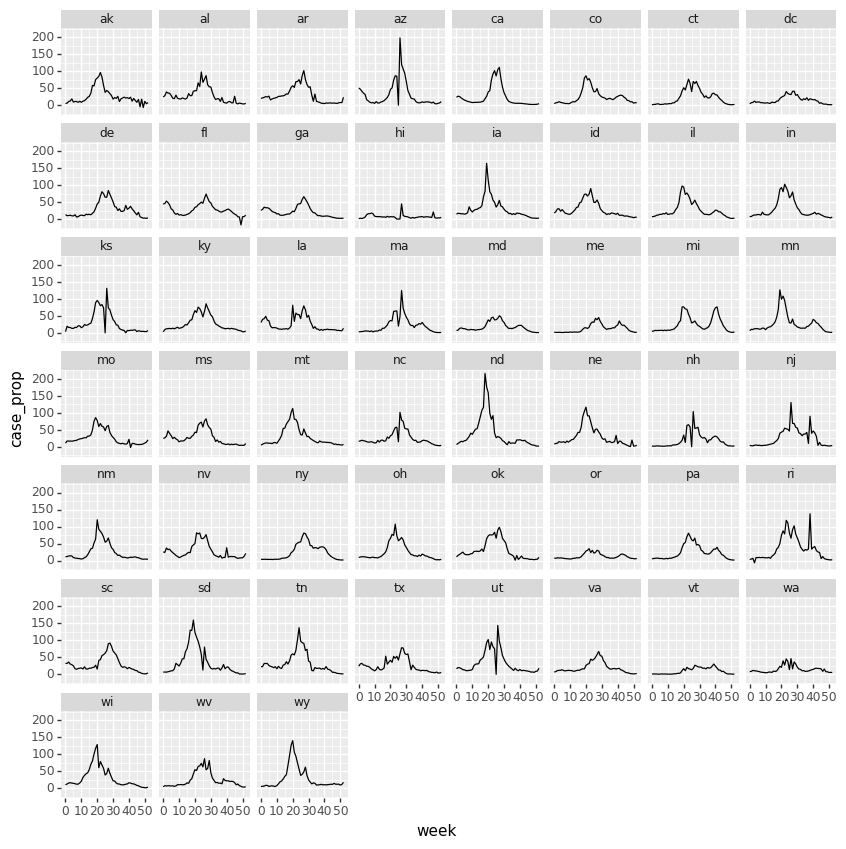

<ggplot: (8727385130746)>

In [11]:
p9.options.figure_size = (10, 10)

(
    p9.ggplot(data_weekly)
    + p9.geom_line(p9.aes(x = 'week', y = 'case_prop'))
    + p9.facet_wrap('~ geo_value')
)

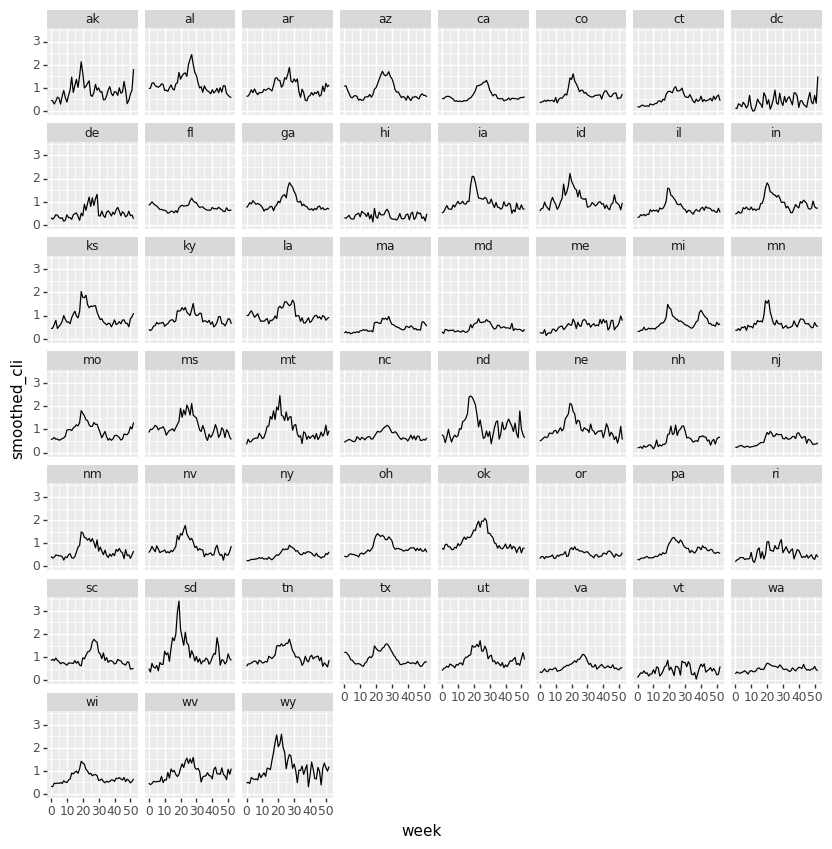

<ggplot: (8727387011024)>

In [9]:
p9.options.figure_size = (10, 10)

(
    p9.ggplot(data_weekly)
    + p9.geom_line(p9.aes(x = 'week', y = 'smoothed_cli'))
    + p9.facet_wrap('~ geo_value')
)

In [12]:
data_weekly.dtypes

week                     int64
geo_value               object
index                  float64
case_prop              float64
smoothed_cli           float64
timestamp       datetime64[ns]
dtype: object

## Using AutoGluon.TimeSeries

First, we need to read in the data as a `TimeSeriesDataFrame` using the `.from_data_frame` method.  This requires the existence of an `item_id` (int) and `timestamp` (datetime) column.  The remainder of the columns are labels and covariates.

In [14]:
train_data = TimeSeriesDataFrame.from_data_frame(
    data_weekly[['timestamp', 'geo_value', 'smoothed_cli', 'case_prop']],
    id_column = 'geo_value'
)

The frequency is inferred by TimeSeries.  This is important in our case because our indicators are at the weekly level, but we want to forecast into the future.  But without infering the frequency we don't know if we should forecast every day, week, month, etc.

In [15]:
train_data.freq

'W-SUN'

In [16]:
help(TimeSeriesDataFrame.from_data_frame)

Help on method from_data_frame in module autogluon.timeseries.dataset.ts_dataframe:

from_data_frame(df: 'pd.DataFrame', id_column: 'Optional[str]' = None, timestamp_column: 'Optional[str]' = None) -> 'TimeSeriesDataFrame' method of builtins.type instance
    Construct a ``TimeSeriesDataFrame`` from a pandas DataFrame.
    
    Parameters
    ----------
    df: pd.DataFrame
        A pd.DataFrame with 'item_id' and 'timestamp' as columns. For example:
    
        .. code-block::
    
               item_id  timestamp  target
            0        0 2019-01-01       0
            1        0 2019-01-02       1
            2        0 2019-01-03       2
            3        1 2019-01-01       3
            4        1 2019-01-02       4
            5        1 2019-01-03       5
            6        2 2019-01-01       6
            7        2 2019-01-02       7
            8        2 2019-01-03       8
    id_column: str
        Name of the 'item_id' column if column name is different
    ti

In [17]:
train_data.head()

,,smoothed_cli,case_prop
item_id,timestamp,,
ak,2020-07-05 23:59:59.999999999,0.463858,4.987448
al,2020-07-05 23:59:59.999999999,0.975983,24.000657
ar,2020-07-05 23:59:59.999999999,0.632721,20.029553
az,2020-07-05 23:59:59.999999999,1.067833,50.877186
ca,2020-07-05 23:59:59.999999999,0.540273,23.244213


TimeSeriesPredictor will forecast into the future for `prediction_length` time points, and so we will split the data into training data (up to `prediction_length` time points into the past), test data (the last `prediction_length` time points).

In [18]:
prediction_length = 5

test_data = train_data.copy()  # the full data set

# the data set with the last prediction_length time steps included, i.e., akin to `a[:-5]`
# test_data = train_data.slice_by_timestep(slice(-prediction_length, None))
train_data = train_data.slice_by_timestep(slice(None, -prediction_length))

Now we train our predictor, which requires a `target` (label) variable, the `prediction_length`, and an evaluation metrics (`MAPE`, `mean_wQuantileLoss`, etc.)

In [19]:
help(TimeSeriesPredictor)

Help on class TimeSeriesPredictor in module autogluon.timeseries.predictor:

class TimeSeriesPredictor(builtins.object)
 |  TimeSeriesPredictor(target: Union[str, NoneType] = None, eval_metric: Union[str, NoneType] = None, path: Union[str, NoneType] = None, verbosity: int = 2, prediction_length: int = 1, quantile_levels: Union[List[float], NoneType] = None, **kwargs)
 |  
 |  AutoGluon ``TimeSeriesPredictor`` predicts future values of multiple related time-series by fitting
 |  global time series models.
 |  
 |  ``TimeSeriesPredictor`` provides probabilistic (distributional) forecasts for univariate time series, where the
 |  time series model is essentially a mapping from the past of the time series to its future of length (i.e., forecast
 |  horizon) defined by the user. Models are trained to give both forecast "means" (i.e., conditional expectations of
 |  future values of a time series given its past), and quantiles of forecast distributions.
 |  
 |  ``TimeSeriesPredictor`` model

In [20]:
train_data['smoothed_cli']

item_id  timestamp                    
ak       2020-07-05 23:59:59.999999999    0.463858
         2020-07-12 23:59:59.999999999    0.442573
         2020-07-19 23:59:59.999999999    0.304653
         2020-07-26 23:59:59.999999999    0.428646
         2020-08-02 23:59:59.999999999    0.600614
                                            ...   
wy       2021-05-02 23:59:59.999999999    0.670385
         2021-05-09 23:59:59.999999999    0.652212
         2021-05-16 23:59:59.999999999    1.153809
         2021-05-23 23:59:59.999999999    0.975161
         2021-05-30 23:59:59.999999999    0.394460
Name: smoothed_cli, Length: 2448, dtype: float64

### Forecasting Smoothed CLI

In [21]:
predictor = TimeSeriesPredictor(
    path="autogluon-covidforecast",
    target="smoothed_cli",
    prediction_length=prediction_length,
    eval_metric="MAPE",
)
predictor.fit(
    train_data=train_data,
    presets="low_quality",
)

presets is set to low_quality
================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: low_quality
Fitting with arguments:
{'evaluation_metric': 'MAPE',
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'toy',
 'prediction_length': 5,
 'target_column': 'smoothed_cli',
 'time_limit': None}
Provided training data set with 2448 rows, 51 items. Average time series length is 48.0.
Training artifacts will be saved to: /home/ubuntu/autogluon/timeseries/notebooks/autogluon-covidforecast
Provided columns ['case_prop'] will not be used.
Validation data is None, will hold the last prediction_length 5 time steps out to use as validation set.

Starting training. Start time is 2022-08-11 21:53:03
Models that will be trained: ['AutoETS', 'SimpleFeedForward', 'DeepAR', 'ARIMA', 'Transformer']
Training timeseries model AutoETS. 
	-0.2543       = Validation score (-MAPE)
	0.83    s     = Training runtime
	3.08    s     = Validation (prediction) ru

In [22]:
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Different set of items than those provided during training were provided for prediction. The model AutoETS will be re-trained on newly provided data
Different set of items than those provided during training were provided for prediction. The model ARIMA will be re-trained on newly provided data


               model  score_test  score_val  pred_time_test  pred_time_val  fit_time_marginal  fit_order
0  SimpleFeedForward   -0.231403  -0.227243        0.243296       0.228491           2.028157          2
1        Transformer   -0.241490  -0.226019        0.464955       0.455432           3.856718          5
2              ARIMA   -0.244361  -0.221487        7.167283       5.383709           1.308776          4
3            AutoETS   -0.249276  -0.254331        3.631276       3.075995           0.827321          1
4             DeepAR   -0.256266  -0.231260        0.428406       0.411975           4.263417          3


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,SimpleFeedForward,-0.231403,-0.227243,0.243296,0.228491,2.028157,2
1,Transformer,-0.241490,-0.226019,0.464955,0.455432,3.856718,5
2,ARIMA,-0.244361,-0.221487,7.167283,5.383709,1.308776,4
3,AutoETS,-0.249276,-0.254331,3.631276,3.075995,0.827321,1
4,DeepAR,-0.256266,-0.231260,0.428406,0.411975,4.263417,3


In [23]:
predictions = predictor.predict(train_data)

Model not specified in predict, will default to the model with the best validation score: ARIMA
Different set of items than those provided during training were provided for prediction. The model ARIMA will be re-trained on newly provided data


In [24]:
help(predictor.predict)

Help on method predict in module autogluon.timeseries.predictor:

predict(data: autogluon.timeseries.dataset.ts_dataframe.TimeSeriesDataFrame, model: Union[str, NoneType] = None, **kwargs) -> autogluon.timeseries.dataset.ts_dataframe.TimeSeriesDataFrame method of autogluon.timeseries.predictor.TimeSeriesPredictor instance
    Return quantile and mean forecasts given a dataset to predict with.
    
    Parameters
    ----------
    data: TimeSeriesDataFrame
        Time series data to forecast with.
    model: str, default=None
        Name of the model that you would like to use for forecasting. If None, it will by default use the
        best model from trainer.



In [43]:
test_preds = predictions.join(test_data)

test_preds = pd.DataFrame(test_preds)
train_df = pd.DataFrame(train_data)

In [44]:
predictions.head()

mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                      
ak      2021-06-06  0.879110  0.523102  0.645312  0.733435  0.808732   
        2021-06-13  0.871094  0.449435  0.594182  0.698554  0.787737   
        2021-06-20  0.866006  0.420628  0.573517  0.683761  0.777960   
        2021-06-27  0.862776  0.408194  0.564243  0.676765  0.772911   
        2021-07-04  0.860727  0.402488  0.559792  0.673219  0.770139   

                         0.5       0.6       0.7       0.8       0.9  
item_id timestamp                                                     
ak      2021-06-06  0.879110  0.949488  1.024785  1.112907  1.235117  
        2021-06-13  0.871094  0.954450  1.043633  1.148005  1.292752  
        2021-06-20  0.866006  0.954051  1.048251  1.158494  1.311383  
        2021-06-27  0.862776  0.952642  1.048788  1.161310  1.317359  
        2021-07-04  0.860727  0.951315  1.048235  1.161662  1.318966

/home/ubuntu/ag-env/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 2 rows containing missing values.


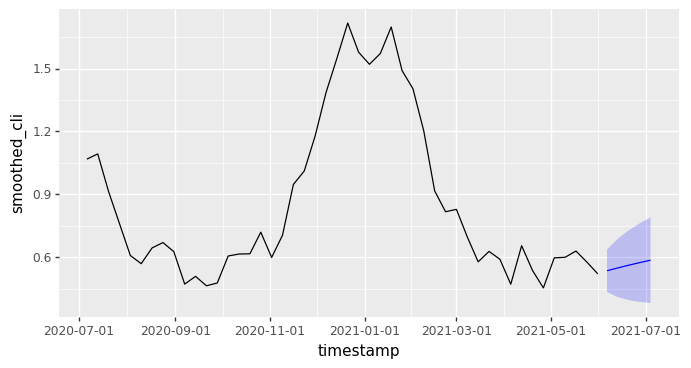

<ggplot: (8727328745265)>

In [45]:
p9.options.figure_size = (8, 4)
indicator = 'smoothed_cli'

(
    p9.ggplot(test_preds.loc[('az',)].reset_index()) 
    + p9.geom_line(p9.aes(x = 'timestamp', y = indicator), color='r')
    + p9.geom_line(train_df.loc[('az',)].reset_index(), p9.aes(x='timestamp', y = indicator))
    + p9.geom_line(test_preds.loc[('az',)].reset_index(), p9.aes(x='timestamp', y='mean'), color='b')
    + p9.geom_ribbon(test_preds.loc[('az',)].reset_index(), p9.aes(x='timestamp', ymin='0.2', ymax='0.8'), fill='blue', alpha=.2)
)

In [47]:
train_plt = (
    train_df
    .reset_index(level=0)
    .loc['2021-04-01':]
    .set_index('item_id', append=True)
    .reorder_levels(['item_id','timestamp'])
)

/tmp/ipykernel_24540/859856460.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.


/home/ubuntu/ag-env/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 2 rows containing missing values.


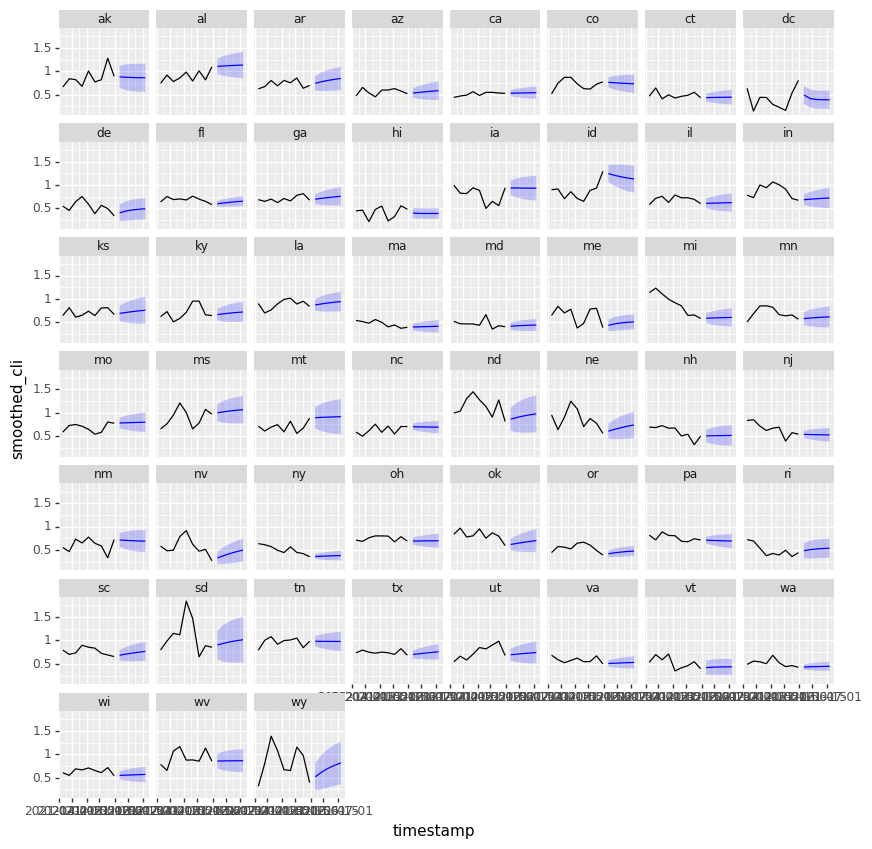

<ggplot: (8727328692336)>

In [49]:
p9.options.figure_size = (10, 10)

(
    p9.ggplot(test_preds.reset_index()) 
    + p9.geom_line(p9.aes(x = 'timestamp', y = indicator), color='r')
    + p9.geom_line(train_plt.reset_index(), p9.aes(x='timestamp', y = indicator))
    + p9.geom_line(test_preds.reset_index(), p9.aes(x='timestamp', y='mean'), color='b')
    + p9.geom_ribbon(test_preds.reset_index(), p9.aes(x='timestamp', ymin='0.2', ymax='0.8'), fill='blue', alpha=.2)
    + p9.facet_wrap('~ item_id')
)

### Forecasting Case Proportion

In [52]:
predictor = TimeSeriesPredictor(
    path="autogluon-covidforecast",
    target="case_prop",
    prediction_length=prediction_length,
    eval_metric="MAPE",
)
predictor.fit(
    train_data=train_data,
    presets="low_quality",
)

Learner random seed set to 0
presets is set to low_quality
================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: low_quality
Fitting with arguments:
{'evaluation_metric': 'MAPE',
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'toy',
 'prediction_length': 5,
 'target_column': 'case_prop',
 'time_limit': None}
Provided training data set with 2448 rows, 51 items. Average time series length is 48.0.
Training artifacts will be saved to: /home/ubuntu/autogluon/timeseries/notebooks/autogluon-covidforecast
Provided columns ['smoothed_cli'] will not be used.
Validation data is None, will hold the last prediction_length 5 time steps out to use as validation set.
AutoGluon will save models to autogluon-covidforecast/

Starting training. Start time is 2022-08-11 22:20:20
Models that will be trained: ['AutoETS', 'SimpleFeedForward', 'DeepAR', 'ARIMA', 'Transformer']
Training timeseries model AutoETS. 
	-1.0240       = Validation score (

In [53]:
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Different set of items than those provided during training were provided for prediction. The model AutoETS will be re-trained on newly provided data
Different set of items than those provided during training were provided for prediction. The model ARIMA will be re-trained on newly provided data


               model  score_test  score_val  pred_time_test  pred_time_val  fit_time_marginal  fit_order
0  SimpleFeedForward   -0.766089  -0.934522        0.245020       0.224604           1.883251          2
1   WeightedEnsemble   -0.955306  -0.864630        0.427653       0.402156          19.835105          6
2             DeepAR   -0.969570  -0.848024        0.433552       0.402156           4.319993          3
3            AutoETS   -1.138302  -1.024035        3.726039       3.059577           0.583167          1
4        Transformer   -2.645881  -1.852082        0.454956       0.444430           3.920662          5
5              ARIMA   -2.693197  -1.400093        6.740563       5.440778           1.132157          4


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,SimpleFeedForward,-0.766089,-0.934522,0.245020,0.224604,1.883251,2
1,WeightedEnsemble,-0.955306,-0.864630,0.427653,0.402156,19.835105,6
2,DeepAR,-0.969570,-0.848024,0.433552,0.402156,4.319993,3
3,AutoETS,-1.138302,-1.024035,3.726039,3.059577,0.583167,1
4,Transformer,-2.645881,-1.852082,0.454956,0.444430,3.920662,5
5,ARIMA,-2.693197,-1.400093,6.740563,5.440778,1.132157,4


In [54]:
predictions = predictor.predict(train_data)

Model not specified in predict, will default to the model with the best validation score: DeepAR


In [55]:
help(predictor.predict)

Help on method predict in module autogluon.timeseries.predictor:

predict(data: autogluon.timeseries.dataset.ts_dataframe.TimeSeriesDataFrame, model: Union[str, NoneType] = None, **kwargs) -> autogluon.timeseries.dataset.ts_dataframe.TimeSeriesDataFrame method of autogluon.timeseries.predictor.TimeSeriesPredictor instance
    Return quantile and mean forecasts given a dataset to predict with.
    
    Parameters
    ----------
    data: TimeSeriesDataFrame
        Time series data to forecast with.
    model: str, default=None
        Name of the model that you would like to use for forecasting. If None, it will by default use the
        best model from trainer.



In [61]:
test_data

,,smoothed_cli,case_prop
item_id,timestamp,,
ak,2020-07-05 23:59:59.999999999,0.463858,4.987448
al,2020-07-05 23:59:59.999999999,0.975983,24.000657
ar,2020-07-05 23:59:59.999999999,0.632721,20.029553
az,2020-07-05 23:59:59.999999999,1.067833,50.877186
ca,2020-07-05 23:59:59.999999999,0.540273,23.244213
...,...,...,...
vt,2021-07-04 23:59:59.999999999,0.598142,0.802121
wa,2021-07-04 23:59:59.999999999,0.416048,5.420081
wi,2021-07-04 23:59:59.999999999,0.653394,3.056070


In [62]:
test_preds = predictions.join(test_data)

test_preds = pd.DataFrame(test_preds)
train_df = pd.DataFrame(train_data)

In [63]:
predictions.head()

mean       0.1       0.2       0.3  \
item_id timestamp                                                               
ak      2021-06-06 23:59:59.999999999  8.079184  3.017204  5.216633  6.008465   
        2021-06-13 23:59:59.999999999  6.706362  0.493548  3.044661  5.131689   
        2021-06-20 23:59:59.999999999  6.397554  2.098841  3.656171  4.983237   
        2021-06-27 23:59:59.999999999  4.632158  0.858920  2.340356  3.522019   
        2021-07-04 23:59:59.999999999  6.344489  1.362640  3.457160  4.353131   

                                            0.4       0.5       0.6       0.7  \
item_id timestamp                                                               
ak      2021-06-06 23:59:59.999999999  6.825262  7.729918  8.752475  9.460279   
        2021-06-13 23:59:59.999999999  6.142845  6.891379  7.693810  8.887482   
        2021-06-20 23:59:59.999999999  5.544324  6.236981  6.833361  7.865086   
        2021-06-27 23:59:59.999999999  3.954682  4.598425  5.296016  6.282558   
        2021-07-04 23:59:59.999999999  5.199933  5.732023  6.636274  7.392235   

                                             0.8        0.9  
item_id timestamp                                            
ak      2021-06-06 23:59:59.999999999  10.648798  12.325315  
        2021-06-13 23:59:59.999999999  10.282841  11.579822  
        2021-06-20 23:59:59.999999999   8.757258  10.906548  
        2021-06-27 23:59:59.999999999   7.491208   9.571295  
        2021-07-04 23:59:59.999999999   9.491817  11.296537

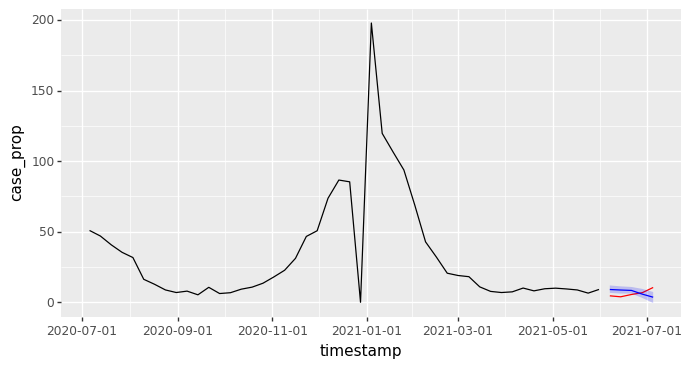

<ggplot: (8727327094516)>

In [64]:
p9.options.figure_size = (8, 4)
indicator = 'case_prop'

(
    p9.ggplot(test_preds.loc[('az',)].reset_index()) 
    + p9.geom_line(p9.aes(x = 'timestamp', y = indicator), color='r')
    + p9.geom_line(train_df.loc[('az',)].reset_index(), p9.aes(x='timestamp', y = indicator))
    + p9.geom_line(test_preds.loc[('az',)].reset_index(), p9.aes(x='timestamp', y='mean'), color='b')
    + p9.geom_ribbon(test_preds.loc[('az',)].reset_index(), p9.aes(x='timestamp', ymin='0.2', ymax='0.8'), fill='blue', alpha=.2)
)

In [65]:
train_plt = (
    train_df
    .reset_index(level=0)
    .loc['2021-04-01':]
    .set_index('item_id', append=True)
    .reorder_levels(['item_id','timestamp'])
)

/tmp/ipykernel_24540/859856460.py:2: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.


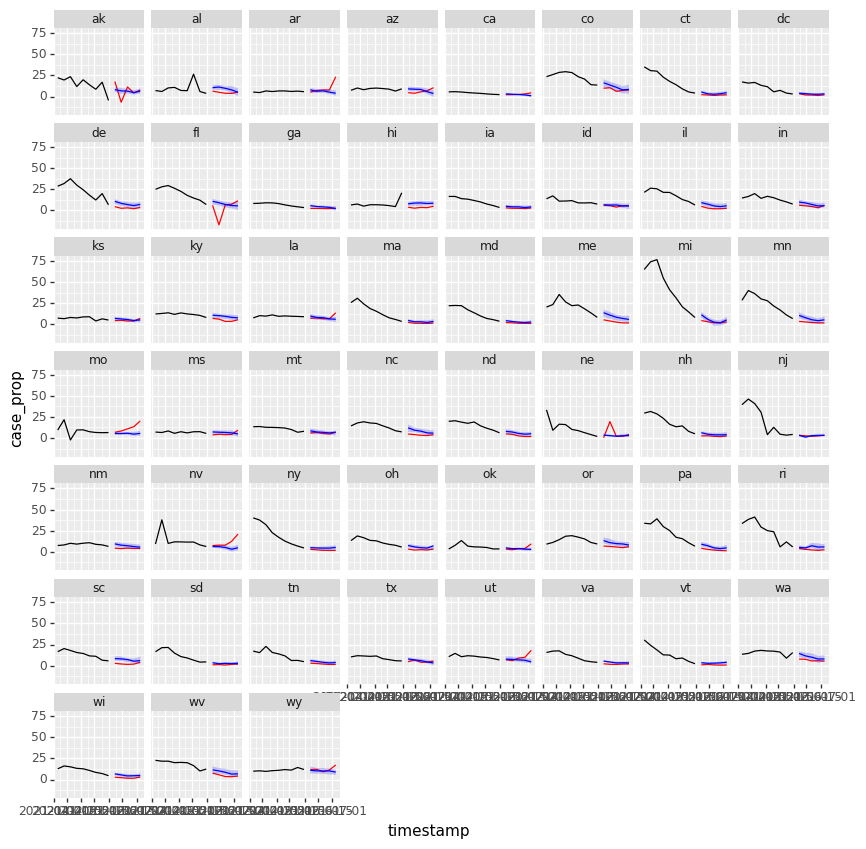

<ggplot: (8727331201973)>

In [66]:
p9.options.figure_size = (10, 10)

(
    p9.ggplot(test_preds.reset_index()) 
    + p9.geom_line(p9.aes(x = 'timestamp', y = indicator), color='r')
    + p9.geom_line(train_plt.reset_index(), p9.aes(x='timestamp', y = indicator))
    + p9.geom_line(test_preds.reset_index(), p9.aes(x='timestamp', y='mean'), color='b')
    + p9.geom_ribbon(test_preds.reset_index(), p9.aes(x='timestamp', ymin='0.2', ymax='0.8'), fill='blue', alpha=.2)
    + p9.facet_wrap('~ item_id')
)